In [301]:
#!/usr/bin/python

from IPython.display import Image
import sys
import pickle
from matplotlib import pyplot as plt
import os
import pprint
import pandas as pd
import seaborn as sns
import time
import numpy as np

%matplotlib inline


sys.path.append("F:/Users/Me/Google Drive\Udacity/Data_Science_Nano_Degree/Intro_to_machine_learning/ud120-projects/tools")


In [302]:
os.getcwd()

'F:\\Users\\Me\\Google Drive\\Udacity\\Data_Science_Nano_Degree\\Intro_to_machine_learning\\ud120-projects\\final_project\\Udacity_Intro_machine_learning'

In his presentation "Machine Learning Gremlins" Ben Hammer suggests the following process model for tackling machine learning problems:

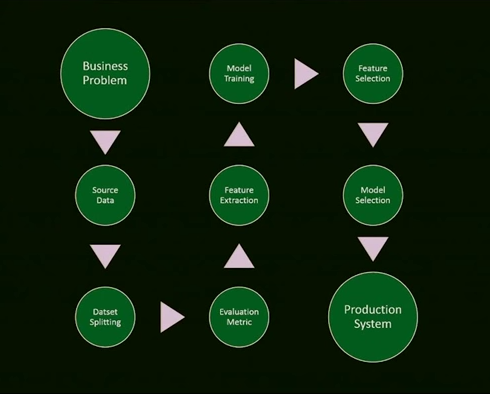

In [303]:
Image(filename='Machine-Learning-Process.png') 

Common issues to look at for include:

* Data leakage
    - introducing information about your classification target which has nothing to to with the actual target
        - grass in background of dog photos
        - previous prostate surgery for identifying prostate cancer
    - to avoid:  it is important to understand what the most important variables are in your model and how they are being used
* Overfitting
    - to avoid:  pay close attention to training error vs validation error or k-fold cross validation
    - make sure to split the data into training and testing sets

#Task 0:  Explore the data
Before getting into the machine learning exercies, we first need to load and explore the Enron dataset.

In [304]:
#navigate up one folder with "../" prefix
#we need to deserialize, extract the data structure from byte code, using the pickle module
enron_data = pickle.load(open("final_project_dataset.pkl", "r"))

Now let's look at the type of data structure and the size of it

In [305]:
print ("Data type: {}".format(type(enron_data)))
data_entries = len(enron_data)
print("length of Enron dictionary is {}".format(data_entries))

Data type: <type 'dict'>
length of Enron dictionary is 146


So we have a dictionary of lengh 146. Let's see what's in it:

In [306]:
#for data in enron_data:
#    print (data, enron_data[data])

Given that the dictionary keys for enron_data are people let's print out the list of attributes for each person:

In [307]:
pprint.pprint(enron_data["METTS MARK"])
features = len(enron_data["METTS MARK"])
print("\n Each person in the Enron dataset has {} features".format(features))

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

 Each person in the Enron dataset has 21 features


Now let's identify hom many poi's are in the dataset?

In [308]:
def poi_count():
    poi_count = 0
    for i in enron_data:
        #print enron_data[i]["poi"]
        if enron_data[i]["poi"] == True:
            poi_count += 1
    return "total poi count = %s" %poi_count

poi_count()  

'total poi count = 18'

With 18 poi's, we have 128 non-poi's (146-18).  Now let's look at the number of NaN's in the dataset for each feature:

In [309]:
NaNs = {}
for person in enron_data:
    for feature in enron_data[person]:
        if enron_data[person][feature] == "NaN":
            if feature in NaNs:
                NaNs[feature] += 1.
            else:
                NaNs[feature] = 1.

pprint.pprint(NaNs)



{'bonus': 64.0,
 'deferral_payments': 107.0,
 'deferred_income': 97.0,
 'director_fees': 129.0,
 'email_address': 35.0,
 'exercised_stock_options': 44.0,
 'expenses': 51.0,
 'from_messages': 60.0,
 'from_poi_to_this_person': 60.0,
 'from_this_person_to_poi': 60.0,
 'loan_advances': 142.0,
 'long_term_incentive': 80.0,
 'other': 53.0,
 'restricted_stock': 36.0,
 'restricted_stock_deferred': 128.0,
 'salary': 51.0,
 'shared_receipt_with_poi': 60.0,
 'to_messages': 60.0,
 'total_payments': 21.0,
 'total_stock_value': 20.0}


Several features have a lot of NaNs.  Features with the highest number of NaNs are unlikely to be useful as features in our model.

In [310]:
#here we find the percentage of NaNs for each feature to aid in feature selection
for feature in NaNs:
    NaNs[feature] = NaNs[feature]/data_entries

pprint.pprint(NaNs)
        

{'bonus': 0.4383561643835616,
 'deferral_payments': 0.7328767123287672,
 'deferred_income': 0.6643835616438356,
 'director_fees': 0.8835616438356164,
 'email_address': 0.23972602739726026,
 'exercised_stock_options': 0.3013698630136986,
 'expenses': 0.3493150684931507,
 'from_messages': 0.410958904109589,
 'from_poi_to_this_person': 0.410958904109589,
 'from_this_person_to_poi': 0.410958904109589,
 'loan_advances': 0.9726027397260274,
 'long_term_incentive': 0.547945205479452,
 'other': 0.363013698630137,
 'restricted_stock': 0.2465753424657534,
 'restricted_stock_deferred': 0.8767123287671232,
 'salary': 0.3493150684931507,
 'shared_receipt_with_poi': 0.410958904109589,
 'to_messages': 0.410958904109589,
 'total_payments': 0.14383561643835616,
 'total_stock_value': 0.136986301369863}


#Task 1a:  Select Features

Here is a list of all the financial features available in the dataset:

In [311]:
financial_features = ["poi",  'bonus', 'deferral_payments', 'deferred_income', 
                      'director_fees', 'exercised_stock_options', 'expenses', 
                      'loan_advances', 'long_term_incentive', 'restricted_stock', 
                      'restricted_stock_deferred', 'salary', 'total_payments', 
                      'total_stock_value']

#Task 3a:  Create new features
Here we create a feature called non-salary referring to total_payments - salary

In [312]:
def non_salary():
    for person in enron_data:
        non_salary = 0
        for feature in financial_features:
            if feature == "total_payments" or feature == "salary" or feature == "poi" or enron_data[person][feature] == "NaN":
                pass
            else:
                non_salary += enron_data[person][feature]
        enron_data[person]["non_salary"] = non_salary
    return enron_data
                #non_salary += enron_data[person][feature]

enron_data = non_salary()
#add non_salary to list of financial features
financial_features.append("non_salary")

In [313]:
print financial_features

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'non_salary']


#Task 2: Remove Outliers


##Load data

In [314]:
print enron_data

{'METTS MARK': {'to_messages': 807, 'deferral_payments': 'NaN', 'expenses': 94299, 'poi': False, 'deferred_income': 'NaN', 'email_address': 'mark.metts@enron.com', 'long_term_incentive': 'NaN', 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 702, 'non_salary': 1864423, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'director_fees': 'NaN', 'bonus': 600000, 'total_stock_value': 585062, 'from_poi_to_this_person': 38, 'from_this_person_to_poi': 1, 'restricted_stock': 585062, 'salary': 365788, 'total_payments': 1061827, 'exercised_stock_options': 'NaN'}, 'BAXTER JOHN C': {'to_messages': 'NaN', 'deferral_payments': 1295738, 'expenses': 11200, 'poi': False, 'deferred_income': -1386055, 'email_address': 'NaN', 'long_term_incentive': 1586055, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 'NaN', 'non_salary': 23953454, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'director_fees': 'NaN', 'bonus': 1200000, 'total_stock_value': 10623

In [315]:
#let's put the financial features into a pandas dataframe and visualize their relationship
df = pd.DataFrame.from_dict(enron_data, orient = "index")#navigate up one folder with "../" prefix 
df_financial = df[financial_features]

In [316]:
## Explore outliers in the financial features

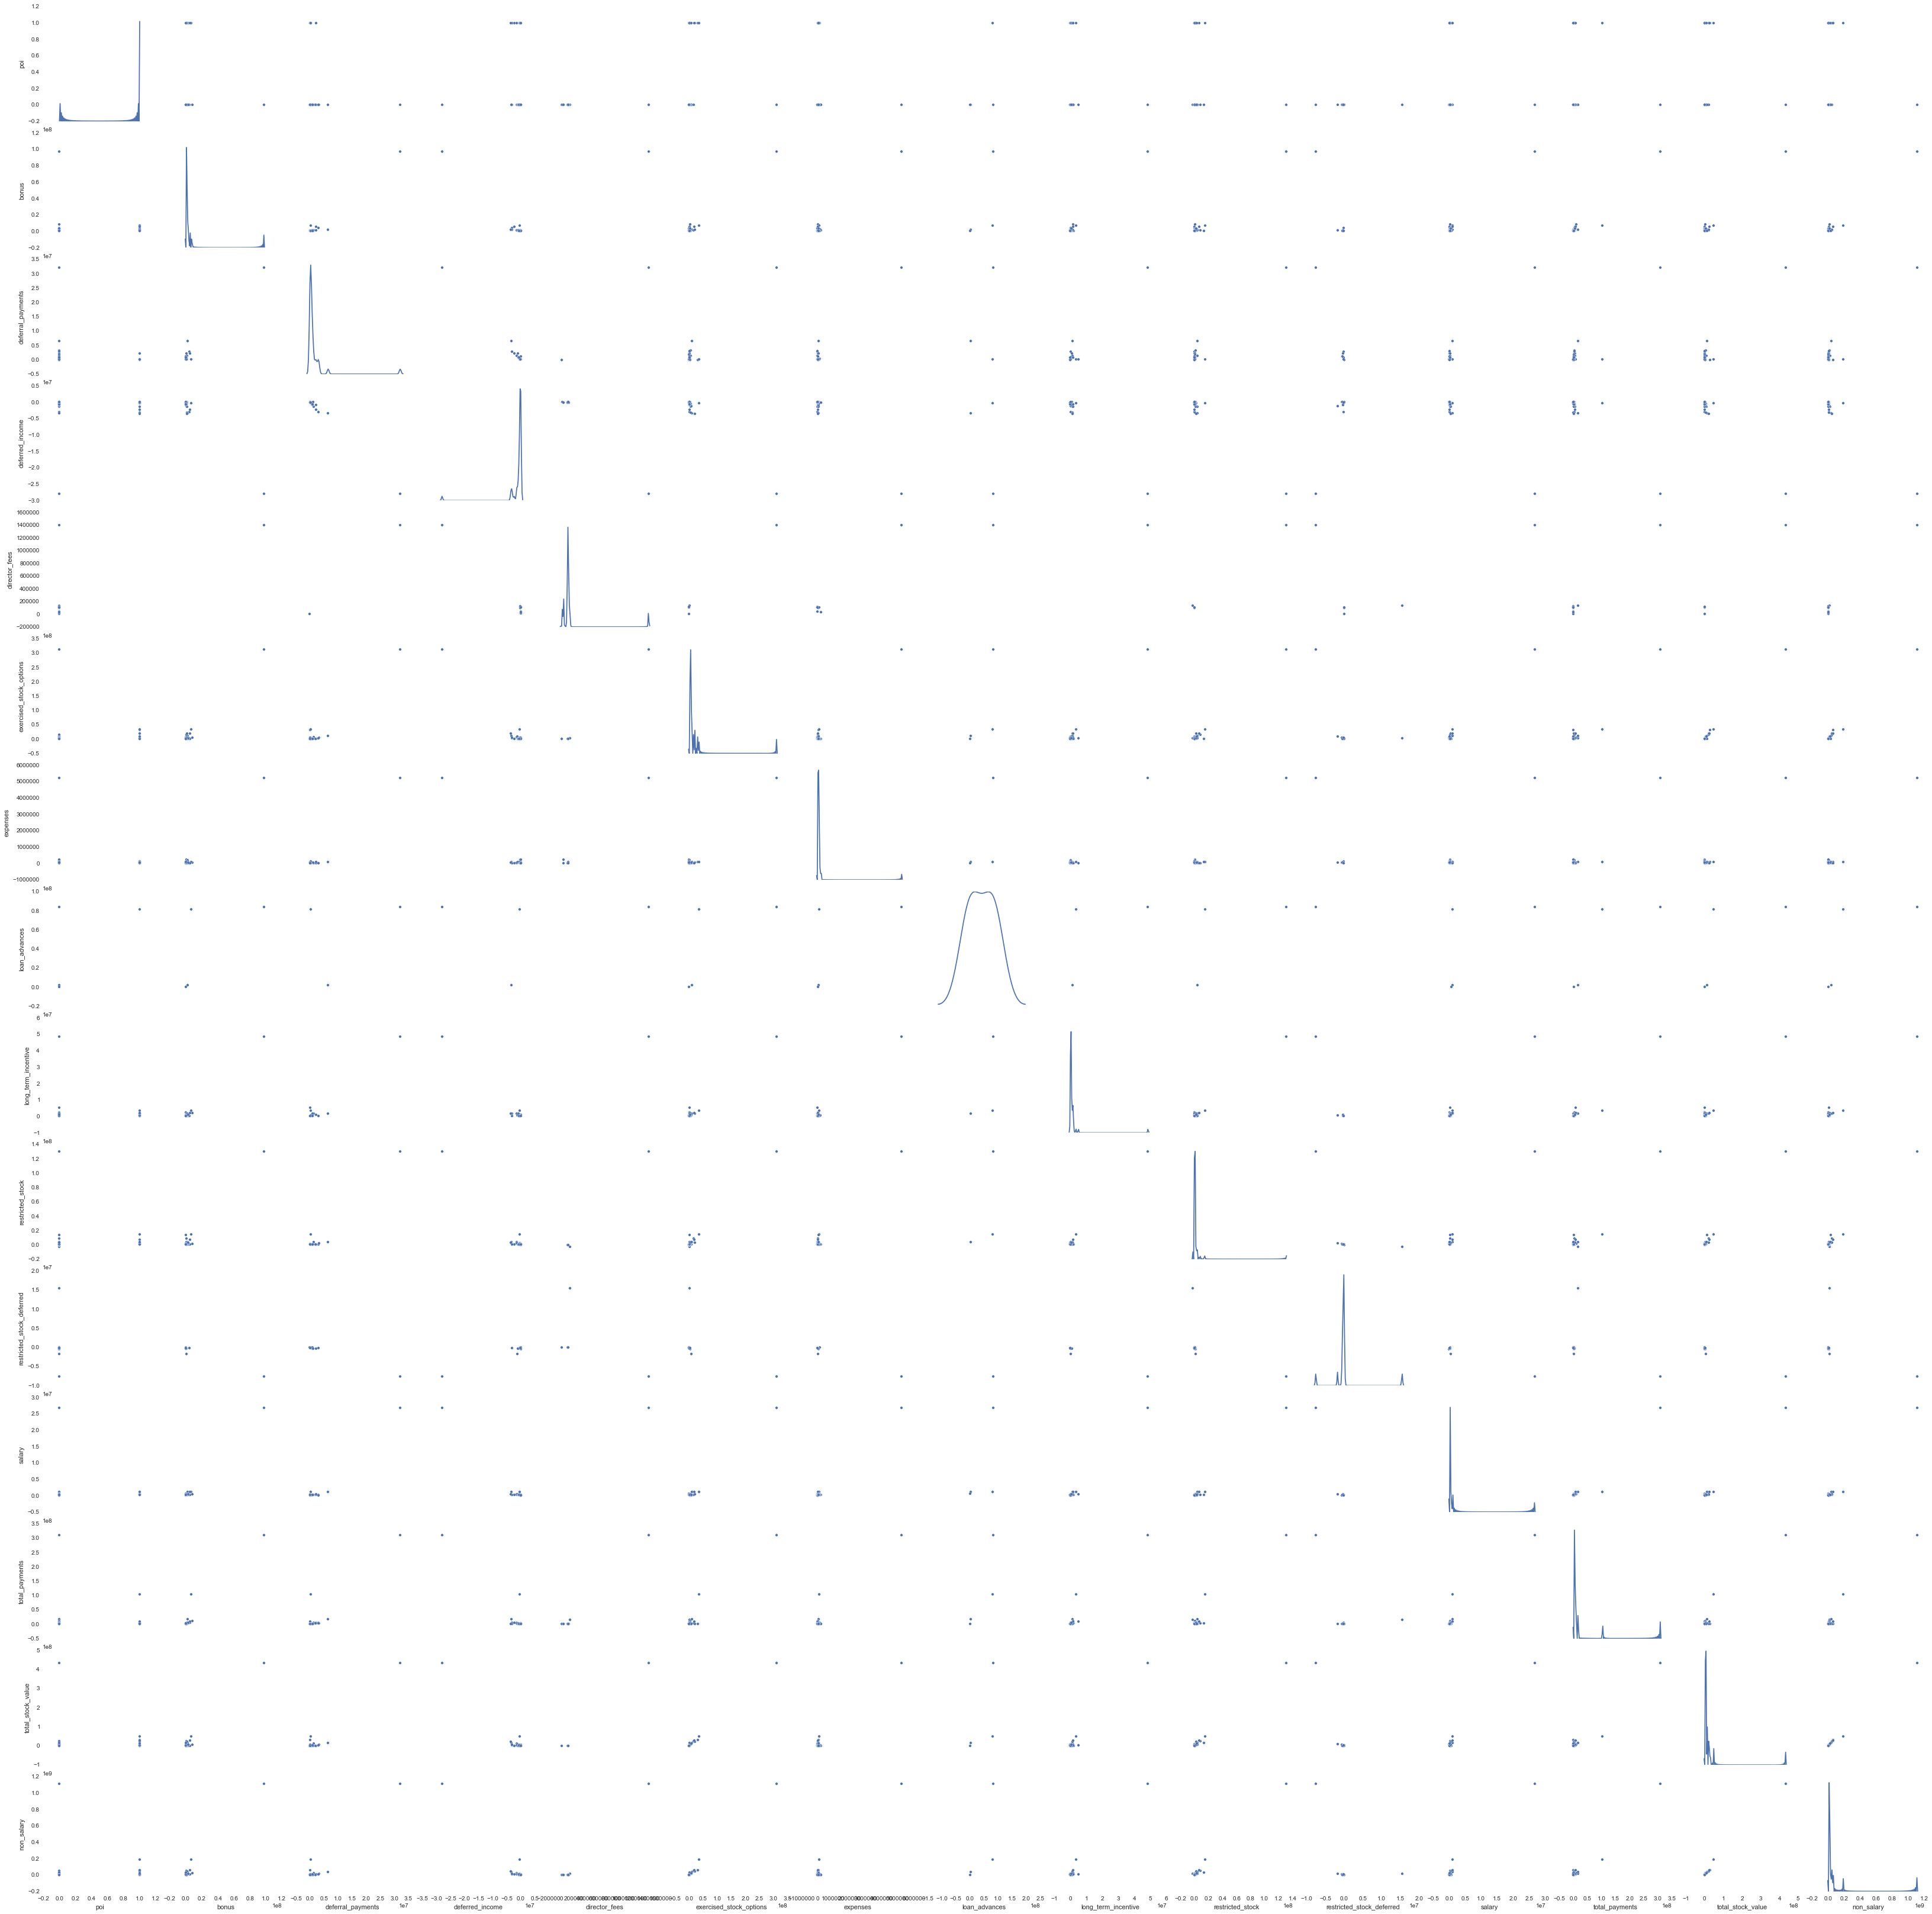

In [317]:

sns.pairplot(df_financial, diag_kind="kde")

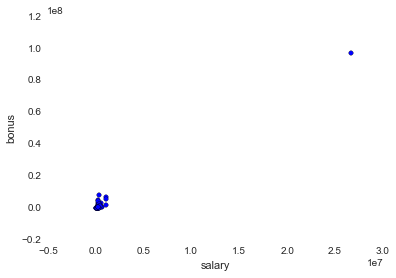

In [318]:
from feature_format import featureFormat, targetFeatureSplit
import matplotlib.pyplot as plt

features = ["salary", "bonus"]


def scatter(x, y):


    #Now plot the data again
    data = featureFormat(enron_data, features)

    for point in data:
        salary = point[0]
        bonus = point[1]
        plt.scatter( salary, bonus )
        plt.xlabel(x)
        plt.ylabel(y)
        
scatter(features[0], features[1])

It looks like we have a number of outliers as all of the data is clusstered in very small areas.  Let's take one financial data pair to investigate the outliers a little further.

Looks like we have a big outlier.  Let's see what the max salary is for the outlier

In [319]:
def max_feature(feature):
    feature_list = []
    for person in enron_data:
        if enron_data[person][feature] != "NaN":
            feature_list.append(enron_data[person][feature])
    return max(feature_list)
    
max_feature("salary")

26704229

Who does this outlier belong to?

In [320]:
def max_person(feature):
    for person in enron_data:
        if enron_data[person][feature] == max_feature(feature):
            return person
            #break
            
max_person("salary")

'TOTAL'

Let's remove this summary statistic and replot the data

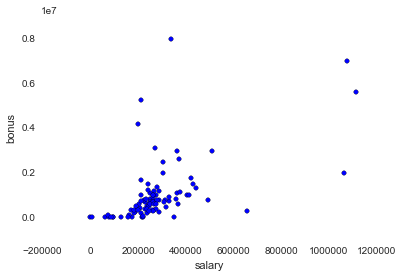

In [321]:
def remove(feature):
    for person in enron_data:
        if enron_data[person][feature] == max_feature(feature):
            enron_data.pop(person, 0 )
            break

remove("salary")
            
scatter(features[0], features[1])

There are stil a few outliers in the data

In [322]:
def salary_outliers():
    outliers = []
    for person in enron_data:
        if enron_data[person]["salary"] > 1000000 or enron_data[person]["bonus"]>5000000:
            if enron_data[person]["salary"] != "NaN" and enron_data[person]["bonus"] != "NaN":
                #print person, data_dict[person]["salary"], data_dict[person]["bonus"]
                outliers.append(person)
    print outliers
    
salary_outliers()

['LAVORATO JOHN J', 'LAY KENNETH L', 'BELDEN TIMOTHY N', 'SKILLING JEFFREY K', 'FREVERT MARK A']


Since the remaining outliers are all people, we'll keep them in the dataset.  But let's just check to see who all the biggest outliers are across all of the financial features:

In [323]:
for feature in financial_features:
    print"Person: ", max_person(feature),"Feature:", feature

Person:  HANNON KEVIN P Feature: poi
Person:  LAVORATO JOHN J Feature: bonus
Person:  FREVERT MARK A Feature: deferral_payments
Person:  BOWEN JR RAYMOND M Feature: deferred_income
Person:  BHATNAGAR SANJAY Feature: director_fees
Person:  LAY KENNETH L Feature: exercised_stock_options
Person:  MCCLELLAN GEORGE Feature: expenses
Person:  LAY KENNETH L Feature: loan_advances
Person:  MARTIN AMANDA K Feature: long_term_incentive
Person:  LAY KENNETH L Feature: restricted_stock
Person:  BHATNAGAR SANJAY Feature: restricted_stock_deferred
Person:  SKILLING JEFFREY K Feature: salary
Person:  LAY KENNETH L Feature: total_payments
Person:  LAY KENNETH L Feature: total_stock_value
Person:  LAY KENNETH L Feature: non_salary


Now let's replot the financial features with a scatter plot matrix

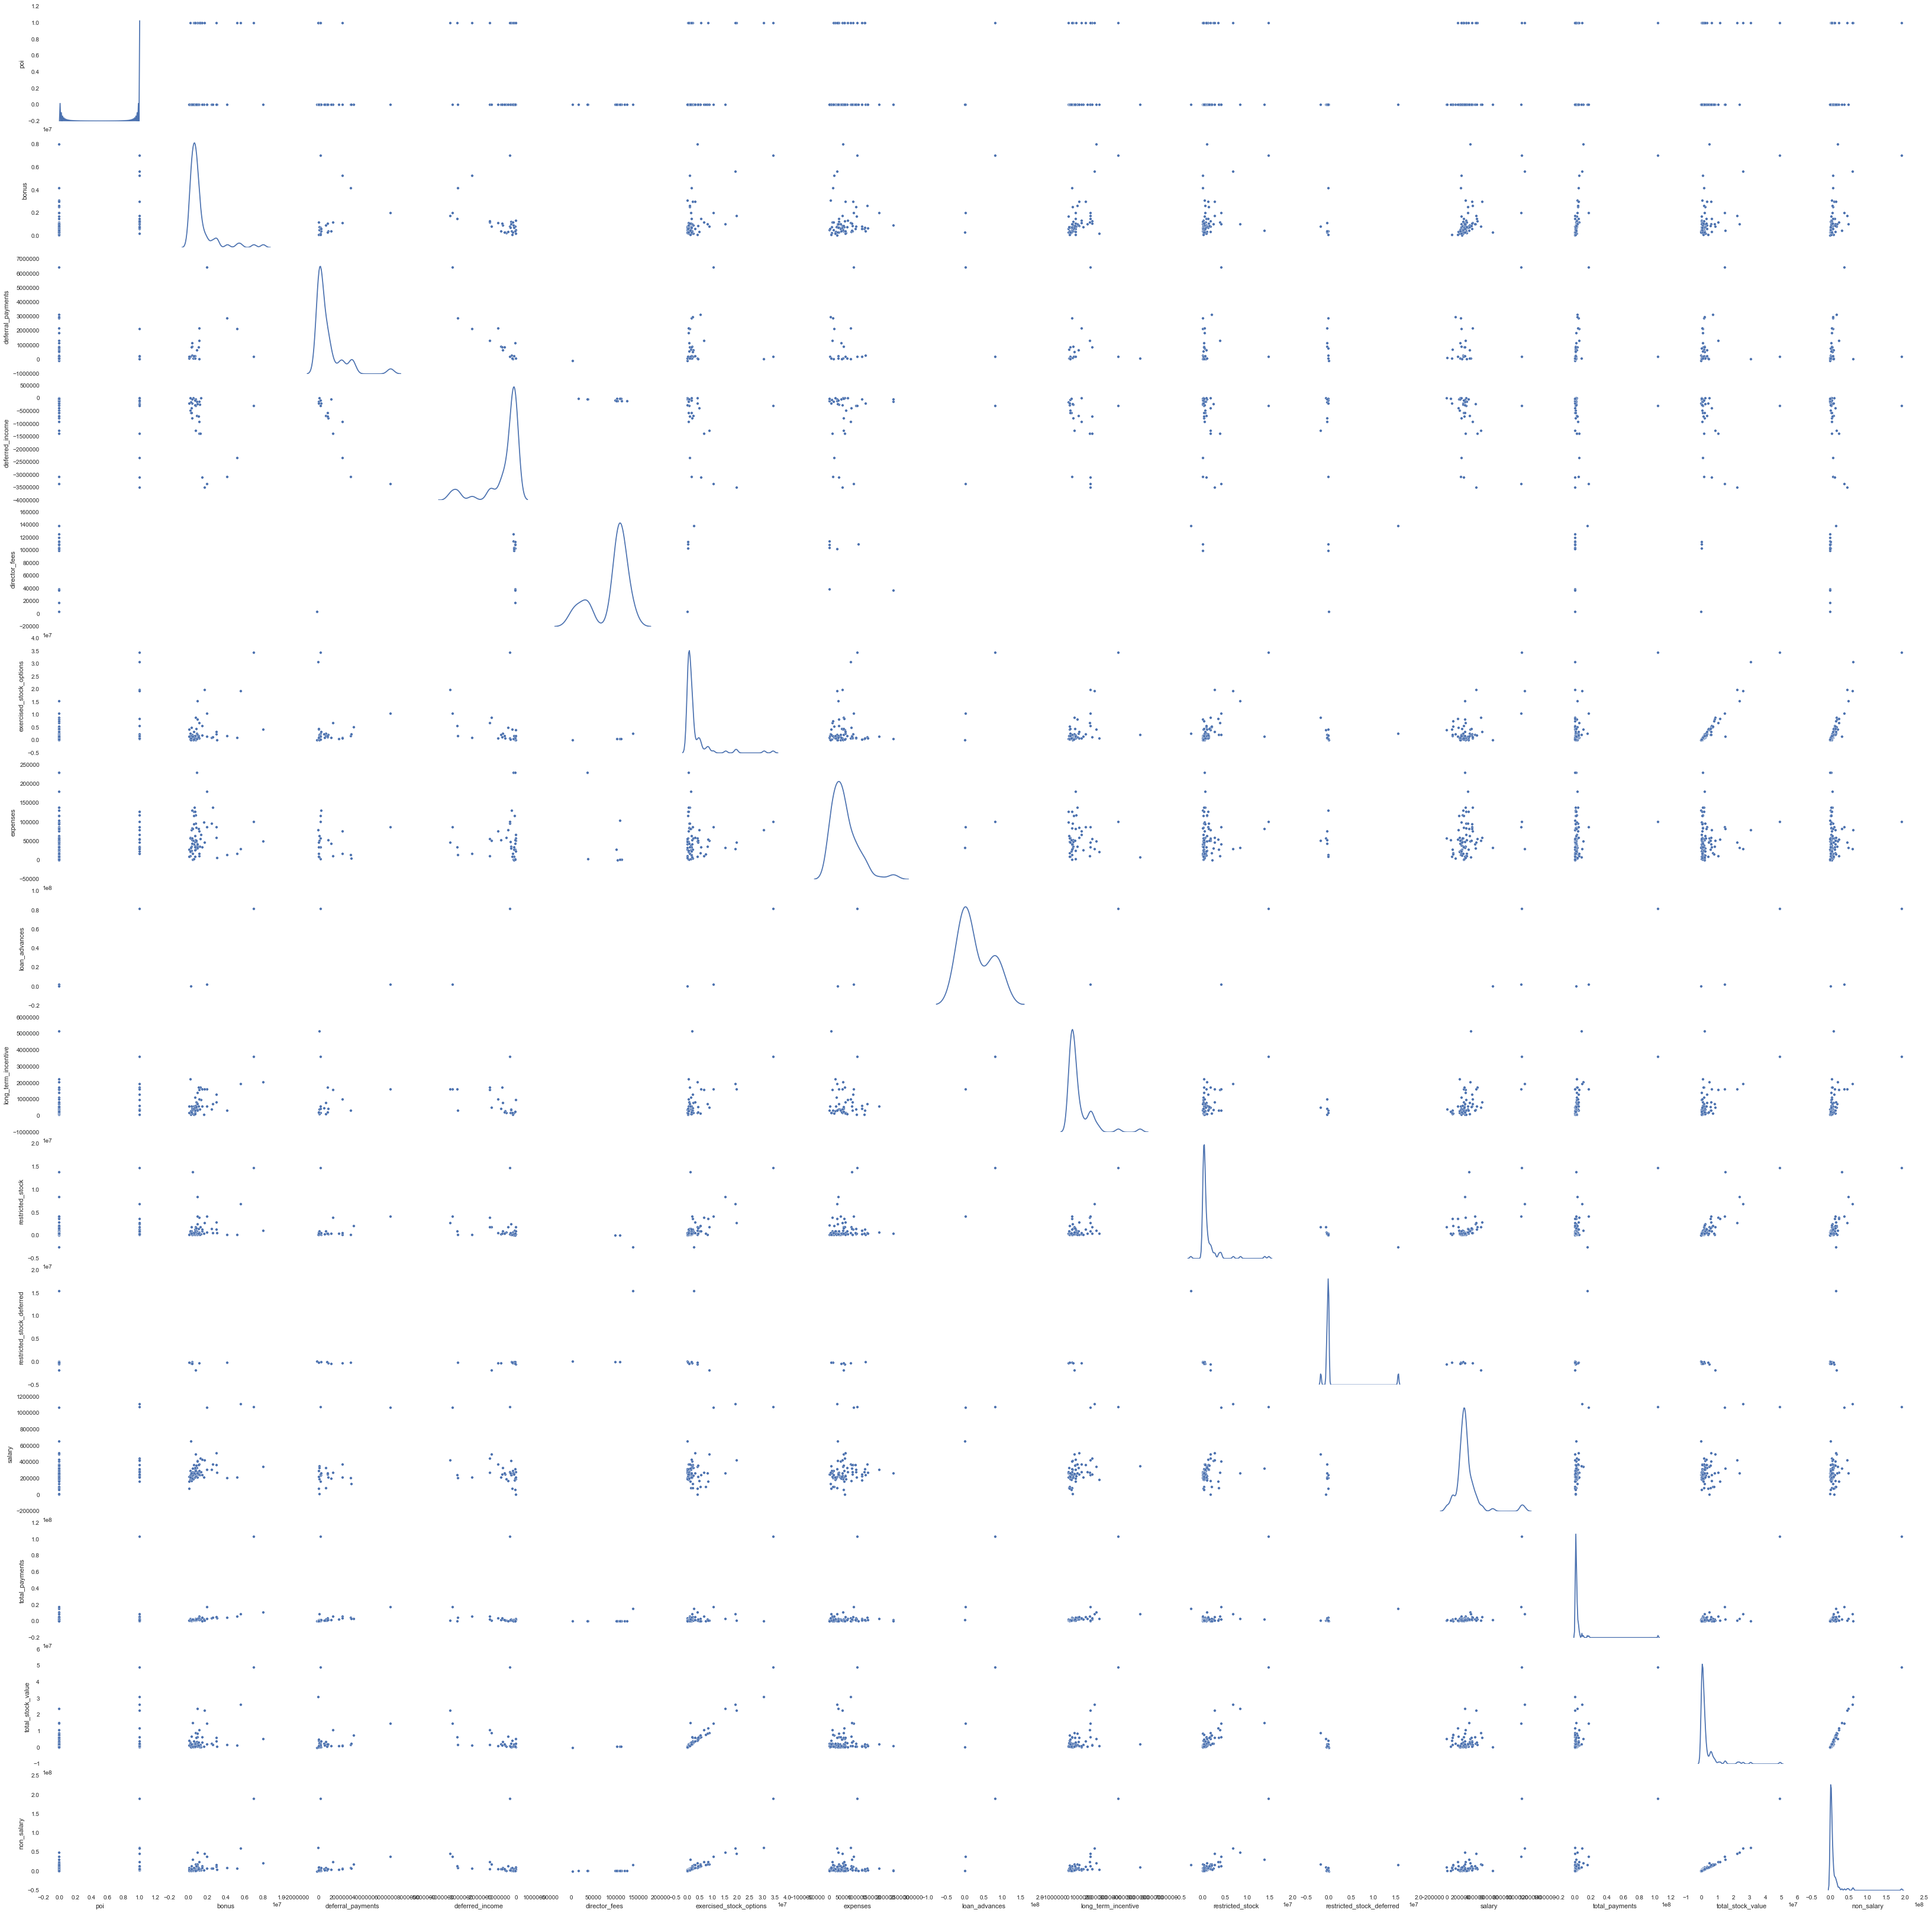

In [324]:
df = pd.DataFrame.from_dict(enron_data, orient = "index")
df_financial = df[financial_features]
sns.pairplot(df_financial, diag_kind="kde")

#Preprocessing Data

In [325]:
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import MinMaxScaler

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from tester import test_classifier, dump_classifier_and_data

from sklearn.grid_search import GridSearchCV
from pprint import pprint



##First we are going to expore Principle Component Analysis

###Step 1:  Re-formate data into a set of numpy arrays and split it into training and testing sets.
When selecting features, make sure to always train your model on a subset of the data to ensure the model isn't overfit.

In [326]:
#guided by lesson 6 regression

#first we need to format the financial features.  
#featureFormat takes a dictionary and a list of features, and returns a numpy array for each feature
#The first feature in the feature list is the poi classification.
#All NaNs are converted to 0, and data points are removed if all of the features are zero.  
data = featureFormat(enron_data, financial_features, remove_NaN =True, remove_all_zeroes = True)
#targetFeatureSplit splits the data into the target (i.e. poi classification) and features
targets, features = targetFeatureSplit(data)


features_train, features_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.5, random_state=42)

###Step 2:  Scaling

In [327]:

####Scale Features
#We need to scale the financial features before applying principle component analysis for feature reduction

scaler = MinMaxScaler()
#fit and transform training data and transform testing data
#http://scikit-learn.org/stable/modules/preprocessing.html
features_scaled = scaler.fit_transform(features)

features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

###Step 4: Dimensionality Reduction with scaled data (all financial features with less than 50% NaNs included here)
Here we take a little detour to explore dimensionality reduction
####Feature Selection & Dimensionality Reduction
Feature selection and dimensionality reduction are both processes of reducing the number of variables we consider in our analysis but they go about reducing the number of variables in different ways.  While features selection involves selecting the most important features (and excluding others from the analysis), dimensionality reduction involves combining features to make new features.  Principle component analysis is a great example of diminsionality reduction.  

[Jason Brownlee](http://machinelearningmastery.com/an-introduction-to-feature-selection/) identifies three general types of feature selection:

* Filter Methods,
* Wrapper Methods, and
* Embedded Methods

Embeded methods learn the best features while the model is being created.  Wrapper methods compare different combinations of features.  Filter methods apply statistical techniques to score each feature.  

####Principle Component Analysis

By setting n_components=n below, we are reducing the n-dimensional space (where n=len(features)) to n principle component dimensions.  These principle components represent the 1st, 2nd, and n dimensions of max variance and the principle components are orthogonal to each other.  If this is confusing, it should because it is impossible to visualize reducing n-dimensions to n dimensions.  

<span style="color: red"> Note that feature scaling is not used here</span>

In [328]:
#guided by lesson 12 mini project
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features)
print pca.explained_variance_ratio_ 
print sum(pca.explained_variance_ratio_)

[ 0.91597475  0.06701875]
0.982993505147


In [329]:
count = 0
for i in financial_features:
    print count, i
    count+=1

0 poi
1 bonus
2 deferral_payments
3 deferred_income
4 director_fees
5 exercised_stock_options
6 expenses
7 loan_advances
8 long_term_incentive
9 restricted_stock
10 restricted_stock_deferred
11 salary
12 total_payments
13 total_stock_value
14 non_salary


####Here we show how to access and plot the first two principle components for bonus and long_term_incentive

In [330]:
#each pca component contains a vector transformation to get from 
#the pca back to the original features
pc_1st = pca.components_[0]
pc_2nd = pca.components_[1]
#pc_3rd = pca.components_[2]

#Each principle component desribes the linear transformation to get 
#from the principle component to the features in financial_features[1:]
print pc_1st

[  3.07321553e-02   4.12981179e-03  -4.99344079e-03  -1.32297805e-04
   1.88444459e-01   3.33757494e-04   2.68331202e-01   1.55655296e-02
   6.88684309e-02   2.18506623e-03   4.89019972e-03   3.60961962e-01
   2.57217213e-01   8.30681888e-01]


In [331]:
#transform the original features into their principle components
transformed_data = pca.transform(features)

#the transformed data expresses each feature in terms of it's n principle components
print transformed_data

[[ -6.36792562e+06   1.95054418e+06]
 [  1.77585703e+07  -6.85297387e+06]
 [  5.46058502e+06  -5.47980453e+06]
 [ -6.36970124e+06   8.28474647e+05]
 [  5.07365593e+06  -5.39449293e+06]
 [ -7.55934523e+06   2.09671514e+06]
 [ -4.34216719e+06   1.67408272e+06]
 [ -6.50814927e+05   1.93561819e+06]
 [  1.02792887e+07  -5.00149430e+06]
 [ -4.70451014e+06   1.60329304e+06]
 [ -1.02480194e+05   4.41619275e+05]
 [ -7.37793684e+06   2.49636442e+06]
 [ -4.28815311e+06   1.74217070e+06]
 [ -5.55676696e+06   2.04339744e+06]
 [ -2.67600133e+06  -3.38621191e+05]
 [ -7.71649335e+06   1.50894087e+06]
 [ -5.63237881e+06   2.02704488e+06]
 [ -1.89390039e+06   1.69431066e+06]
 [ -6.62231831e+06   1.54216487e+06]
 [ -7.21955636e+06   2.03108893e+06]
 [ -6.23566330e+06   7.55503643e+05]
 [  5.61589068e+06  -3.91722855e+06]
 [ -3.48441824e+06   2.94702619e+06]
 [ -8.50834231e+06   1.96863924e+06]
 [ -8.56472560e+06   2.07724707e+06]
 [ -7.81422241e+05   9.48435587e+05]
 [ -8.44255480e+06   2.09142733e+06]
 

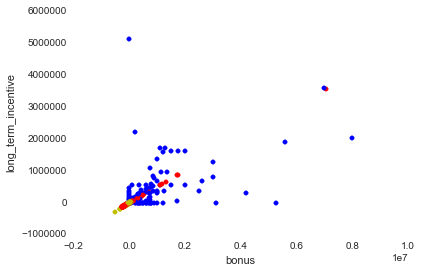

In [332]:
#use zip here to combine each list (transformed data and original data) 
#into a list of tuples iterate through the list of transformed features.
#ii contains the aggregated principle components, and jj contains the 
#original data points for each feature.  
for ii, jj in zip(transformed_data, features):
    #plot the 
    plt.scatter(pc_1st[1-1]*ii[0], pc_1st[8-1]*ii[0], color="r")
    plt.scatter(pc_2nd[1-1]*ii[1], pc_2nd[8-1]*ii[1], color="y")
    plt.scatter(jj[1-1], jj[8-1], color="b")#features doesn't have poi, so the specific feature is i-1

plt.xlabel(financial_features[1])
plt.ylabel(financial_features[8])
plt.show()

####And for comparison, we plot the top two pinciple components for bonus and long_term_incentive

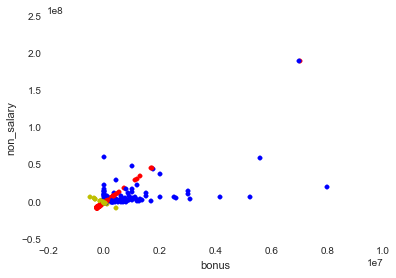

In [333]:
#use zip here to combine each list into a list of tuples
#iterate through the list of transformed original features
for ii, jj in zip(transformed_data, features):
    #plot the 
    plt.scatter(pc_1st[1-1]*ii[0], pc_1st[14-1]*ii[0], color="r")
    plt.scatter(pc_2nd[1-1]*ii[1], pc_2nd[14-1]*ii[1], color="y")
    plt.scatter(jj[1-1], jj[14-1], color="b")

plt.xlabel(financial_features[1])
plt.ylabel(financial_features[14])
plt.show()

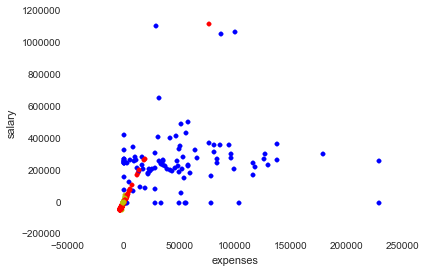

In [334]:
#use zip here to combine each list into a list of tuples
#iterate through the list of transformed original features
for ii, jj in zip(transformed_data, features):
    #plot the 
    plt.scatter(pc_1st[6-1]*ii[0], pc_1st[11-1]*ii[0], color="r")
    plt.scatter(pc_2nd[6-1]*ii[1], pc_2nd[11-1]*ii[1], color="y")
    plt.scatter(jj[6-1], jj[11-1], color="b")

plt.xlabel(financial_features[6])
plt.ylabel(financial_features[11])
plt.show()

####Dimensionality Reduction without normalization
Now let's see what happens when we use PCA without applying feature scaling.  

In [335]:
pca.fit(features_train)

#percentage of variance explained by each of the principle components
pca.explained_variance_ratio_ 

array([ 0.88657628,  0.06487235])

Results from the PCA will be explored further below

###Tasks 4 & 5:  Explore and tune different classifiers

###First we will explore support vector machines for the classification task.

In [368]:
k = range(1,len(financial_features))
print k

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [369]:
#let's set a cross-validation method to use with GridSearchCV
cv = StratifiedShuffleSplit(targets, 100, random_state = 42)

In [366]:
#Let's try creating a classifier using the entire dataset following:
#http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV
#we can use the entire dataset because GridSearchCV applies StratefiedKFold cross-validation with folds=3 as a default parameter
parameters = [{'select__k': k,
               'select__score_func': [f_classif, chi2],
               'classifier__C': [1, 10, 100, 1000]
              }]

pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('select', SelectKBest()),
        ("classifier", LinearSVC())
    ])

scores = ["accuracy", 'precision',"recall"]
clf={}

for score in scores:
    print("Tuning hyper-parameters for %s" % score)
    print()
    
    clf[score] = GridSearchCV(pipeline, parameters, cv = cv, scoring= score)
    clf[score].fit(features, targets)
    print clf[score].best_params_
    
    #pass the best_estimator from gridsearch to the test_classifier
    test_classifier(clf[score].best_estimator_, enron_data, financial_features)

Tuning hyper-parameters for accuracy
()
{'select__score_func': <function chi2 at 0x0000000050A09BA8>, 'select__k': 13, 'classifier__C': 1}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('select', SelectKBest(k=13, score_func=<function chi2 at 0x0000000050A09BA8>)), ('classifier', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.87613	Precision: 0.64549	Recall: 0.15750	F1: 0.25322	F2: 0.18556
	Total predictions: 15000	True positives:  315	False positives:  173	False negatives: 1685	True negatives: 12827

Tuning hyper-parameters for precision
()
{'select__score_func': <function chi2 at 0x0000000050A09BA8>, 'select__k': 13, 'classifier__C': 1}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('select', SelectKBest(k=13, score_func=<function chi2 at 0x0000000

In [339]:
####This is one way to select the parameters tuned using GridSearchCV:

In [340]:
#create a dictionary of parameter:value pairs which had high scores in accuracy, precision and recall
best = clf["recall"].best_params_.copy()

#and access these parameters as you would access any dictionary:
best["classifier__C"]
best["select__score_func"]
best["select__k"]

####Now let's hardcode the k best features

selector = SelectKBest(best["select__score_func"], k=best["select__k"])

#now select kbest features using the total dataset
selector.fit(features_scaled, targets)

#return the univariate scores of each feature
print selector.scores_
print financial_features[1:]

#initialize kBestFeatures by re-introducting "poi" (which is removed when we split targets and features)
kBestFeatures = ["poi"]

#create an array of kBestFeatures
for i in selector.get_support(True):
    kBestFeatures.append(financial_features[i+1])
    
print kBestFeatures

#Here is a table of the score for each feature using SelectKBest
df_features = pd.Series(data=selector.scores_, index= financial_features[1:])
df_features

[ 21.06000171   0.21705893  11.59554766   2.10765594  25.09754153
   6.23420114   7.2427304   10.07245453   9.34670079   0.06498431
  18.57570327   8.86672154  24.46765405  21.14167492]
['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'non_salary']
['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value', 'non_salary']


bonus                        21.060002
deferral_payments             0.217059
deferred_income              11.595548
director_fees                 2.107656
exercised_stock_options      25.097542
expenses                      6.234201
loan_advances                 7.242730
long_term_incentive          10.072455
restricted_stock              9.346701
restricted_stock_deferred     0.064984
salary                       18.575703
total_payments                8.866722
total_stock_value            24.467654
non_salary                   21.141675
dtype: float64

In [341]:
####And here are the scores for LinearSVC() after parameter tunning

In [342]:
#best_estimator_ is the estimator (with tuned parameters), that gives the best score on the held out (i.e. test)  data
pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ("classifier", LinearSVC(C=best["classifier__C"]))
    ])

test_classifier(pipeline, enron_data, kBestFeatures)


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.79260	Precision: 0.23661	Recall: 0.24950	F1: 0.24288	F2: 0.24681
	Total predictions: 15000	True positives:  499	False positives: 1610	False negatives: 1501	True negatives: 11390



###And now let's concatenate PCA and feature selection methods

In [343]:
cv = StratifiedShuffleSplit(targets, 10, random_state = 42)

In [344]:
#http://scikit-learn.org/stable/auto_examples/feature_stacker.html#example-feature-stacker-py

pca = PCA()

selection = SelectKBest()

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

svm = LinearSVC()

pipeline = Pipeline([("scaler", MinMaxScaler()), ("features", combined_features), ("svm", svm)])

param_grid = [{"features__pca__n_components": [1, 2, 3, 4, 5, 6],
                  "features__univ_select__k": k,
                  "features__univ_select__score_func": [f_classif, chi2],
                  "svm__C": [0.1, 1, 10, 100, 1000]
              }]


scores = ["accuracy", "precision", "recall"]

for score in scores:
    print score

    grid_search = GridSearchCV(pipeline, cv = cv, param_grid=param_grid)
    #we can use all of the data because gridsearch applies cross-validation
    grid_search.fit(features, targets)
    print grid_search.best_params_

    test_classifier(grid_search.best_estimator_, enron_data, financial_features)

accuracy
{'features__pca__n_components': 2, 'features__univ_select__score_func': <function chi2 at 0x0000000050A09BA8>, 'svm__C': 0.1, 'features__univ_select__k': 1}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('univ_select', SelectKBest(k=1, score_func=<function chi2 at 0x0000000050A09BA8>))],
       transformer_weights=None)...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86860	Precision: 0.56502	Recall: 0.06300	F1: 0.11336	F2: 0.07661
	Total predictions: 15000	True positives:  126	False positives:   97	False negatives: 1874	True negatives: 12903

precision
{'features__pca__n_components': 1, 'features__univ_select__score_func': <function chi2 at 0x0000000050A09BA8>, 'svm__C': 1000, 'features__univ_select__k': 7}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_r

Some compared to the pipeline above, adding PCA allows us to improve recall scores at a cost to accuracy and precision when scoring=accuracy & scoring=precision.  Oddly the recall score is terrible when recall is passed as the scoring function to gridsearch.

Let's check the results using the turned parameters

###We can also reverse PCA and Feature selection:

Not much better.

####Use LinearSVC() to classify poi's without normalization or feature selection

First without feature selection:

In [347]:
pipeline = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC(C=10))])

test_classifier(pipeline, enron_data, financial_features)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86167	Precision: 0.45007	Recall: 0.16900	F1: 0.24573	F2: 0.19312
	Total predictions: 15000	True positives:  338	False positives:  413	False negatives: 1662	True negatives: 12587



Interesting, so feature selection and PCA reduce recal by a few percent whereas they increase precision by a few percent.

Next without scaling or feature selection.  <span style="color: red">This method is innappropriate </span>because the enron_data is not scaled which impicitly means that features with a larger magnitude have a higher weight in the trained model

In [348]:
pipeline = Pipeline([("svm", LinearSVC(C=10))])

test_classifier(pipeline, enron_data, financial_features)

Pipeline(steps=[('svm', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.73720	Precision: 0.21221	Recall: 0.35800	F1: 0.26647	F2: 0.31475
	Total predictions: 15000	True positives:  716	False positives: 2658	False negatives: 1284	True negatives: 10342



So when we don't use feature scaling recall scores jump by over 20% wehreas precision declines by more than 20% and accuracy declines by over 10%.  This likely implies that the features that are important for recall have a larger magnitude when feature scaling isn't applied and therefore implicily have higher weighting when feature scaling isn't used.

##Adaboost
<span style="color: red"> Warning, Adaboost is very computationally intensive</span>
###Using gridsearch for parameter tuning of Adaboost


In [349]:
cv = StratifiedShuffleSplit(targets, 10, random_state = 42)

In [350]:
parameters = {'features__k': k,
              'features__score_func': [chi2, f_classif],
              'abc__n_estimators': [10, 25, 50, 75, 100, 200]}

pipeline = Pipeline([
        ('scaler', scaler),
        ('features', SelectKBest()),
        ("abc", AdaBoostClassifier())
    ])

scores = ["accuracy", 'precision',"recall"]

clf = {}

for score in scores:
    print("Tuning hyper-parameters for %s" % score)
    clf[score] = GridSearchCV(pipeline, parameters, cv=cv, scoring=score)

    #we can pass all of the data because gridsearch applies cross-validation
    clf[score].fit(features, targets)
    print clf[score].best_params_
    
    #pass the best_estimator from gridsearch to the test_classifier
    test_classifier(clf[score].best_estimator_, enron_data, financial_features)

Tuning hyper-parameters for accuracy
{'features__score_func': <function f_classif at 0x0000000050A099E8>, 'features__k': 10, 'abc__n_estimators': 10}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', SelectKBest(k=10, score_func=<function f_classif at 0x0000000050A099E8>)), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None))])
	Accuracy: 0.84527	Precision: 0.35859	Recall: 0.20350	F1: 0.25965	F2: 0.22277
	Total predictions: 15000	True positives:  407	False positives:  728	False negatives: 1593	True negatives: 12272

Tuning hyper-parameters for precision
{'features__score_func': <function f_classif at 0x0000000050A099E8>, 'features__k': 11, 'abc__n_estimators': 100}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', SelectKBest(k=11, score_func=<function f_classif at 0x0000000050A099E8>)), ('abc', AdaBoostClassifier(algorithm='SAMME

Using GridSearchCV to tune Adaboost parameters, accuracy and precision scores remain high and recall scores approach the .3 threshold.

In [351]:
def createSelector(tunedClassifier):
    
    selector = SelectKBest(tunedClassifier["features__score_func"], k=tunedClassifier["features__k"])

    #now select kbest features using the total dataset
    return selector.fit(features_scaled, targets)

def selectFeatures(selector):
    #create an array of kBestFeatures
    #initialize kBestFeatures with "poi" (which is removed when we split targets and features)
    kBestFeatures = ["poi"]
    
    #.get_support(True) returns an array of indices for accessing features each of the kBestFeatures
    for i in selector.get_support(True):
        kBestFeatures.append(financial_features[i+1])
    return kBestFeatures

In [352]:
####Now let's "hardcode" the k best features based on the best_estimator results above

In [353]:
#create a dictionary of parameter:value pairs from the tuned classifier
tunedClassifier = clf["precision"].best_params_.copy()

#and access these parameters as you would access any dictionary:

print tunedClassifier["features__k"]
print tunedClassifier["features__score_func"]
print tunedClassifier["abc__n_estimators"]


selector =  createSelector(tunedClassifier)
#return the univariate scores of each feature
print selector.scores_
print financial_features[1:]

kBestFeatures = selectFeatures(selector)
print kBestFeatures

#Here is a table of the score for each feature using SelectKBest
df_features = pd.Series(data=selector.scores_, index= financial_features[1:])
df_features

11
<function f_classif at 0x0000000050A099E8>
100
[ 21.06000171   0.21705893  11.59554766   2.10765594  25.09754153
   6.23420114   7.2427304   10.07245453   9.34670079   0.06498431
  18.57570327   8.86672154  24.46765405  21.14167492]
['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'non_salary']
['poi', 'bonus', 'deferred_income', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value', 'non_salary']


bonus                        21.060002
deferral_payments             0.217059
deferred_income              11.595548
director_fees                 2.107656
exercised_stock_options      25.097542
expenses                      6.234201
loan_advances                 7.242730
long_term_incentive          10.072455
restricted_stock              9.346701
restricted_stock_deferred     0.064984
salary                       18.575703
total_payments                8.866722
total_stock_value            24.467654
non_salary                   21.141675
dtype: float64

So here is our tuned algorithm with the kBestFeatures sent to the classifier:

These results are equivalent to those reported above with SelectKBest passed through the pipeline and scoring="precision".  Let's explore another routine to validate the model.

<span style="color:red">Surprisingly, it seems that limiting the number of features for SelectKBest leads to large improvements for accuracy, precision and recall compared to results given above using GridSearchCV.</span>  This may have to do with the limited number of n_iters passed to StratefiedShuffleSplit as I have noticed this issue before.  

####RandomForestClassifier
<span style="color: red"> Warning, RandomForestClassifier is very computationally intensive</span>. And the preliminary results are only mediocore...

In [354]:
cv = StratifiedShuffleSplit(targets, 5, random_state = 42)

In [355]:
#double underscore notation:  http://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv
parameters = {
    "features__k": k,
    "features__score_func": [chi2, f_classif],
    'clf__max_depth': [None,1,2,3,4], 
    'clf__n_estimators':[10],
    'clf__min_samples_split': [1,2,3,4,5,6,7], 
    "clf__min_samples_leaf": [1,2,3,4,5],
    "clf__max_leaf_nodes": [2,3,4,5,6,7]
}

pipeline = Pipeline([
            ('scaler', MinMaxScaler()), 
            ('features', SelectKBest()),
            ('clf', RandomForestClassifier())
        ])


scores = ["accuracy", 'precision',"recall"]

clf = {}

for score in scores:
    print("Tuning hyper-parameters for %s" % score)
    print()
    clf[score] = GridSearchCV(pipeline, parameters, cv=cv, scoring=score)

    #we can pass all of the data because gridsearch applies cross-validation
    clf[score].fit(features, targets)
    print clf[score].best_params_
    print()
    
    #pass the best_estimator from gridsearch to the test_classifier
    test_classifier(clf[score].best_estimator_, enron_data, financial_features)

Tuning hyper-parameters for accuracy
{'features__k': 5, 'clf__n_estimators': 10, 'clf__max_leaf_nodes': 7, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'features__score_func': <function f_classif at 0x0000000050A099E8>, 'clf__min_samples_split': 5}
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', SelectKBest(k=5, score_func=<function f_classif at 0x0000000050A099E8>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.86387	Precision: 0.47506	Recall: 0.20000	F1: 0.28149	F2: 0.22619
	Total predictions: 15000	True positives:  400	False positives:  442	False negatives: 1600	True negatives: 12558

Tuning hyper-parameters for precision
{'features__k': 12, 'clf__n_estimators': 10, 'clf__max_leaf_nodes': 3, 'clf__max_depth': None, 'clf_

###K nearest neighbors classifier

In [356]:
cv = StratifiedShuffleSplit(targets, 100, random_state = 42)

In [362]:
#double underscore notation:  http://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv
parameters = {
    'features__k': k,
    "features__score_func": [chi2, f_classif],
    'clf__n_neighbors': [1,2,3,4,5,6,7,8], 
    'clf__weights': ['uniform', 'distance'],
    'clf__leaf_size': [10, 30], 
    "clf__p": [1,2]

}


pipeline = Pipeline([
        ('scaler', scaler),
        ('features', SelectKBest()),
        ('clf', KNeighborsClassifier())
    ])

scores = ["accuracy", 'precision',"recall"]

clf = {}

cv = StratifiedShuffleSplit(targets, 10, random_state = 42)

for score in scores:
    print("Tuning hyper-parameters for %s" % score)
    print
    clf[score] = GridSearchCV(pipeline, parameters, cv = cv, scoring=score)

    #we can pass all of the data because gridsearch applies cross-validation
    clf[score].fit(features, targets)
    print clf[score].best_params_
    print
    
    #pass the best_estimator from gridsearch to the test_classifier
    test_classifier(clf[score].best_estimator_, enron_data, financial_features)

Tuning hyper-parameters for accuracy
()
{'features__k': 5, 'clf__p': 2, 'clf__weights': 'uniform', 'clf__n_neighbors': 2, 'clf__leaf_size': 5, 'features__score_func': <function chi2 at 0x0000000050A09BA8>}
()
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', SelectKBest(k=5, score_func=<function chi2 at 0x0000000050A09BA8>)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_neighbors=2, p=2, weights='uniform'))])
	Accuracy: 0.87920	Precision: 0.66906	Recall: 0.18600	F1: 0.29108	F2: 0.21739
	Total predictions: 15000	True positives:  372	False positives:  184	False negatives: 1628	True negatives: 12816

Tuning hyper-parameters for precision
()
{'features__k': 4, 'clf__p': 1, 'clf__weights': 'uniform', 'clf__n_neighbors': 3, 'clf__leaf_size': 5, 'features__score_func': <function chi2 at 0x0000000050A09BA8>}
()
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('fe

###It looks like we have a winner!

####Now let's "hard code" the features used in our algorithm

In [358]:
#create a dictionary of parameter:value pairs from the tuned classifier
tunedParams = clf["precision"].best_params_.copy()

#and access these parameters as you would access any dictionary:

print tunedParams["features__k"]
print tunedParams["features__score_func"]
print tunedParams["clf__n_neighbors"]
print tunedParams["clf__weights"]
print tunedParams["clf__leaf_size"]
print tunedParams["clf__p"]

selector =  createSelector(tunedParams)


print financial_features[1:]



print kBestFeatures

#return a table with the univariate scores of each feature using SelectKBest
df_features = pd.Series(data=selector.scores_, index= financial_features[1:])
df_features

4
<function chi2 at 0x0000000050A09BA8>
3
uniform
10
1
['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'non_salary']
['poi', 'bonus', 'exercised_stock_options', 'loan_advances', 'total_stock_value']


bonus                        5.193349
deferral_payments            0.058561
deferred_income              0.341726
director_fees                1.489217
exercised_stock_options      6.927477
expenses                     1.525657
loan_advances                6.742748
long_term_incentive          2.579690
restricted_stock             0.595438
restricted_stock_deferred    0.003456
salary                       3.116644
total_payments               2.811509
total_stock_value            5.544840
non_salary                   4.291605
dtype: float64

Here is our tuned algorithm with the kBestFeatures sent to the classifier:

In [359]:
pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ("classifier", KNeighborsClassifier(n_neighbors=tunedParams["clf__n_neighbors"], 
                                            weights=tunedParams["clf__weights"], 
                                            leaf_size=tunedParams["clf__leaf_size"], 
                                            p=tunedParams["clf__p"]))
    ])

test_classifier(pipeline, enron_data, kBestFeatures)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_neighbors=3, p=1, weights='uniform'))])
	Accuracy: 0.88462	Precision: 0.74272	Recall: 0.38250	F1: 0.50495	F2: 0.42359
	Total predictions: 13000	True positives:  765	False positives:  265	False negatives: 1235	True negatives: 10735



###Data dump

In [360]:

### Dump your classifier, dataset, and features_list so 
### anyone can run/check your results.

dump_classifier_and_data(pipeline, enron_data, kBestFeatures)